In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math

# Add rpy2
%load_ext rpy2.ipython

In [26]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsignif)
    library(ggVennDiagram)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

## How does each SPI perform in distinguishing (1) stimulus type and (2) relevance type, using averaged epochs compared across participants?

We can load the results from the logistic regression classification for (1) stimulus type and (2) relevance type):

In [87]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load classification res -- update to where you have stored your classification results
classification_res_path = f"{deriv_dir}/classification_results/across_participants"
averaged_stimulus_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_classification_results.csv")
averaged_relevance_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_classification_results.csv")

# Add meta_ROI_pair column that combines the 'from' and 'to' meta-ROIs
averaged_stimulus_type_classification_res["meta_ROI_pair"] = averaged_stimulus_type_classification_res.meta_ROI_from + "__" + averaged_stimulus_type_classification_res.meta_ROI_to
averaged_relevance_type_classification_res["meta_ROI_pair"] = averaged_relevance_type_classification_res.meta_ROI_from + "__" + averaged_relevance_type_classification_res.meta_ROI_to

# Load in pyspi results
for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
    pyspi_res_averaged = pd.read_csv(f"{pyspi_res_path_averaged}/{pyspi_res_file}")
    all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)

# Concatenate pyspi results
all_pyspi_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list)

In [4]:
# Try classification from Category_Selective to Prefrontal_Cortex
pyspi_data_of_interest = all_pyspi_res_averaged_epochs.query("meta_ROI_from == 'Category_Selective' & \
                                                             meta_ROI_to == 'Prefrontal_Cortex' & \
                                                             relevance_type == 'Relevant non-target' & \
                                                             stimulus_presentation == 'on' & \
                                                             stimulus_type in ['face', 'False']")

pyspi_data_of_interest.head()

,index,SPI,meta_ROI_from,meta_ROI_to,value,stimulus_type,relevance_type,duration,stimulus_presentation,subject_ID,stimulus
5190,8,cov_EmpiricalCovariance,Category_Selective,Prefrontal_Cortex,0.102341,False,Relevant non-target,1000,on,CA107,on
5202,24,cov_GraphicalLasso,Category_Selective,Prefrontal_Cortex,0.092340,False,Relevant non-target,1000,on,CA107,on
5214,40,cov_GraphicalLassoCV,Category_Selective,Prefrontal_Cortex,0.008540,False,Relevant non-target,1000,on,CA107,on
5226,56,cov_LedoitWolf,Category_Selective,Prefrontal_Cortex,0.099967,False,Relevant non-target,1000,on,CA107,on
5238,72,cov_OAS,Category_Selective,Prefrontal_Cortex,0.100187,False,Relevant non-target,1000,on,CA107,on


## What is the overall distribution in SPI performance per classification task?

Before diving into any specific result, let's first see the distribution in performance across all SPIs per stimulus task classification problem (e.g., 'Face' vs. 'Object') by meta-ROI pair (e.g., 'GNWT' to 'CS')

In [35]:
%%R -i averaged_stimulus_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
for (relevance_type in unique(averaged_stimulus_type_classification_res$relevance_type)) {
    averaged_stimulus_type_classification_res %>% 
        mutate(Batch_Number = "1") %>%
        # Filter accuracy to >50% for visualization purposes
        filter(accuracy > 0.5, relevance_type==relevance_type) %>%
        mutate(accuracy = 100*accuracy) %>%
        rowwise() %>%
        # Want a specific order for the meta-ROI pair in the plot
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                        "Category_Selective__V1_V2",
                                                        "Category_Selective__IPS",
                                                        "IPS__Category_Selective",
                                                        "IPS__Prefrontal_Cortex",
                                                        "Prefrontal_Cortex__IPS",
                                                        "Prefrontal_Cortex__V1_V2",
                                                        "V1_V2__Prefrontal_Cortex",
                                                        "V1_V2__IPS",
                                                        "IPS__V1_V2",
                                                        "Prefrontal_Cortex__Category_Selective",
                                                        "Category_Selective__Prefrontal_Cortex")))  %>% 
        mutate(stimulus_combo = factor(stimulus_combo, levels = c("('face', 'letter')", "('face', 'object')",  
                                                                "('false', 'face')",  "('false', 'letter')",
                                                                "('letter', 'object')", "('false', 'object')"))) %>%
        ggplot(data=., mapping=aes(x=stimulus_presentation, y=accuracy, fill=meta_ROI_pair)) +
        # Create half violins colored by meta-ROI pair and stimulus presentation period
        geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
        geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                                size = 1.75, alpha=0.6, stroke=0) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
                show.legend=FALSE, position = position_dodge(width=1.4)) +
        facet_grid(meta_ROI_pair ~ stimulus_combo, scales="free", switch="y") + 
        theme(legend.position = "bottom") +
        scale_x_discrete(expand = c(0, 0)) +
        xlab("Stimulus presentation period") +
        ylab("Cross-validated accuracy by SPI (%)") +
        labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
        theme(strip.background = element_blank(),
            strip.placement="outside",
            legend.position="none",
            panel.spacing = unit(0.5, "lines"),
            axis.text.x = element_text(angle=45, hjust=1)) +
        coord_flip()

    # ggsave(glue('../plots/inter_subject_classification/Stimulus_wise_classification_performance_by_meta_ROI_pair_{relevance_type}.svg'), width=10, height=12, units='in', dpi=300)
}


## Examine the top-performing SPI for each ROI pair, zooming in on the top 4

In [19]:
%%R -i averaged_stimulus_type_classification_res -o top_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_res <- averaged_stimulus_type_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex")),
            stimulus_combo = str_replace_all(stimulus_combo, "False", "false"))  %>% 
    # Find maximum accuracy
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy,
           stimulus_combo = factor(stimulus_combo, 
                                   levels = c("('face', 'object')",  
                                              "('false', 'face')",
                                              "('face', 'letter')", 
                                              "('letter', 'object')", 
                                              "('false', 'object')", 
                                              "('false', 'letter')"))) %>% 
    group_by(meta_ROI_pair) %>%
    mutate(is_max = ifelse(accuracy==max(accuracy,na.rm=T), "Max", "Not Max"))
                                              
top_res %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line(linewidth=1.25) +
    geom_point(aes(size=is_max)) + 
    scale_size_manual(values=c("Not Max" = 0, "Max" = 4)) +
    xlab("Stimulus comparison") +
    ylab("Cross-validated accuracy (%)") +
    # Set y-axis breaks to only 60 and 65
    scale_y_continuous(breaks=c(60,65)) +
    scale_x_discrete(expand = c(0.2, 0)) +
    facet_grid(meta_ROI_pair ~ ., scales="free_x") +
    theme(legend.position="none", strip.background = element_blank(),
          strip.placement="outside", strip.text = element_blank(),
          panel.spacing = unit(0.25, "lines"))
# ggsave('../plots/inter_subject_classification/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=4.5, height=8, units='in', dpi=300)

In [7]:
%%R -i averaged_stimulus_type_classification_res -o top_eight_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_eight_res <- averaged_stimulus_type_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy) %>% 
    arrange(desc(accuracy)) %>%
    slice_max(order_by=accuracy, n=8) %>% 
    dplyr::select(meta_ROI_to, meta_ROI_from, SPI, stimulus_combo, stimulus_presentation, relevance_type) %>% 
    mutate(meta_ROI_pair = paste(meta_ROI_from, meta_ROI_to, sep="__"))

In [8]:
pyspi_res_top_SPIs = all_pyspi_res_averaged_epochs.merge(top_eight_res, how='inner')

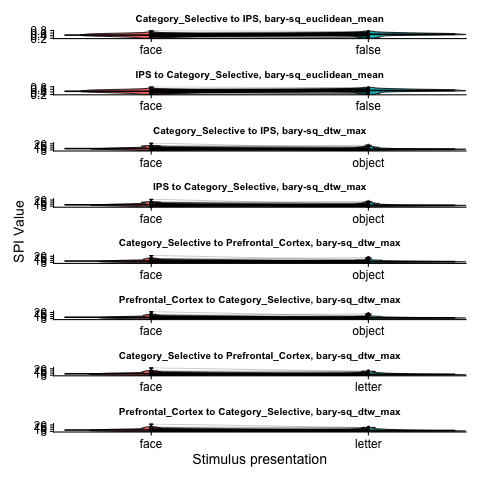

In [9]:
%%R -i top_eight_res,pyspi_res_top_SPIs -o pyspi_res_top_SPIs_subset

plot_list = list()
for (i in 1:nrow(top_eight_res)) {
    this_SPI = top_eight_res$SPI[i]
    this_meta_ROI_from = top_eight_res$meta_ROI_from[i]
    this_meta_ROI_to = top_eight_res$meta_ROI_to[i]
    stimulus_combo = top_eight_res$stimulus_combo[i]

    # Extract first and second stimulus from stimulus_combo
    stimulus_1 = strsplit(stimulus_combo, ",")[[1]][1] %>% str_replace_all(., "\\(|\\)|'| ", "")
    stimulus_2 = strsplit(stimulus_combo, ",")[[1]][2] %>% str_replace_all(., "\\(|\\)|'| ", "")

    # Filter pyspi results for the current meta-ROI pair and stimulus combo
    pyspi_res_top_SPIs_subset = pyspi_res_top_SPIs %>%
        mutate(stimulus_type = ifelse(stimulus_type=="False", "false", stimulus_type)) %>%
        filter(meta_ROI_from == this_meta_ROI_from,
               meta_ROI_to == this_meta_ROI_to,
               SPI == this_SPI,
               stimulus_type %in% c(stimulus_1, stimulus_2))

    p <- pyspi_res_top_SPIs_subset %>% 
        mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
        ungroup() %>%
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex"))) %>% 
        ggplot(data=., mapping=aes(x=stimulus_type, y=value)) +
        geom_violin(aes(fill=stimulus_type)) + 
        geom_point(aes(group=subject_ID), alpha=0.6, size=0.85) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.8, linewidth=0.3, show.legend=FALSE) +
        geom_line(aes(group=subject_ID), alpha=0.2, linewidth=0.5) +
        xlab("Stimulus presentation") +
        ylab("SPI Value") +
        ggtitle(glue("{this_meta_ROI_from} to {this_meta_ROI_to}, {this_SPI}")) +
        # facet_grid(meta_ROI_pair ~ ., scales="free", switch="both") +
        scale_x_discrete(expand=c(0,0)) +
        theme(strip.placement="outside", 
                strip.background=element_blank(),
                legend.position="none")

    plot_list[[i]] <- p
}

wrap_plots(plot_list, ncol=1) +
  plot_layout(axis_titles = "collect") &
  theme(plot.title = element_text(hjust = 0.5, size=10))
# ggsave("../plots/inter_subject_classification/Top_eight_SPIs_by_meta_ROI_pair_and_stimulus_combo.svg", width=4, height=18, units='in', dpi=300)

## Euler diagrams for SPIs greater than 62% accuracy

In [48]:
# Filter to accuracy > 60%
averaged_stimulus_type_classification_res_above_60 = averaged_stimulus_type_classification_res.query("accuracy >= 0.62")

# For each ROI (from or to, doesn't matter), find all of the unique SPIs that have accuracy > 60%
unique_SPIs_from = averaged_stimulus_type_classification_res_above_60.groupby("meta_ROI_from").SPI.unique().reset_index()
unique_SPIs_to = averaged_stimulus_type_classification_res_above_60.groupby("meta_ROI_to").SPI.unique().reset_index()

# Convert from list-column to long format
unique_SPIs_from_long = unique_SPIs_from.explode("SPI")
unique_SPIs_to_long = unique_SPIs_to.explode("SPI")

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


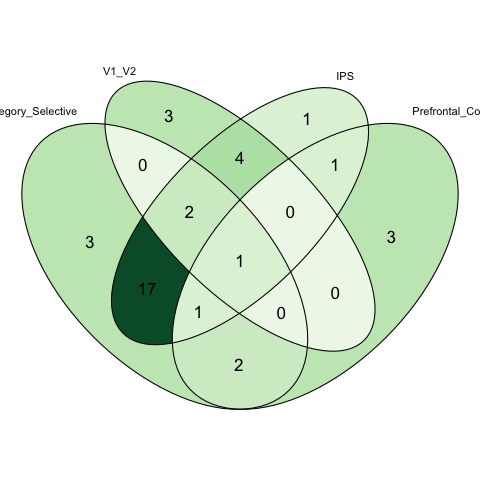

In [49]:
%%R -i unique_SPIs_from_long

SPIs_from_venn <- split(unique_SPIs_from_long, unique_SPIs_from_long$meta_ROI_from)
SPIs_from_venn <- lapply(SPIs_from_venn, function(x) x %>% pull(SPI))
SPIs_from_venn <- SPIs_from_venn[c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")]

venn_from <- Venn(SPIs_from_venn)
data_from <- process_data(venn_from, shape_id = "401f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_from)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_from), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_from)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6,
                data = venn_regionlabel(data_from)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Greens", direction = 1) +
  theme(legend.position="none")
  
# ggsave("../plots/inter_subject_classification/Top_SPIs_from_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


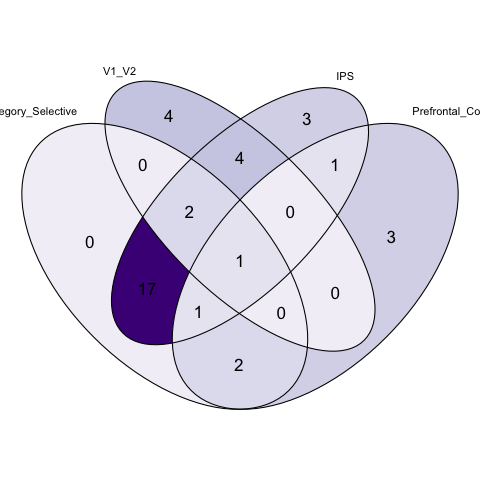

In [50]:
%%R -i unique_SPIs_to_long

SPIs_to_venn <- split(unique_SPIs_to_long, unique_SPIs_to_long$meta_ROI_to)
SPIs_to_venn <- lapply(SPIs_to_venn, function(x) x %>% pull(SPI))
SPIs_to_venn <- SPIs_to_venn[c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")]

venn_to <- Venn(SPIs_to_venn)
data_to <- process_data(venn_to, shape_id = "401f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_to)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_to), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_to)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6, 
                data = venn_regionlabel(data_to)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Purples", direction = 1) +
  labs(fill="# SPIs") +
  theme(legend.position="none")

# ggsave("../plots/inter_subject_classification/Top_SPIs_to_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

## Which SPI is at the center of both Euler diagrams?

In [71]:
unique_SPIs_from_long.head()

,meta_ROI_from,SPI
0,Category_Selective,cov_GraphicalLassoCV
0,Category_Selective,spearmanr
0,Category_Selective,kendalltau
0,Category_Selective,plv_multitaper_max_fs-1_fmin-0_fmax-0-25
0,Category_Selective,gpdcoh_multitaper_max_fs-1_fmin-0_fmax-0-25


In [74]:
%%R -i unique_SPIs_from_long,unique_SPIs_to_long

SPI_all_four_from <- unique_SPIs_from_long %>% 
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 4)

SPI_all_four_to <- unique_SPIs_to_long %>%
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 4)

print(glue("SPIs that are present in all four ROIs (from): {SPI_all_four_from$SPI}"))
print(glue("SPIs that are present in all four ROIs (to): {SPI_all_four_to$SPI}"))

SPIs that are present in all four ROIs (from): bary-sq_softdtw_max
SPIs that are present in all four ROIs (to): bary-sq_softdtw_max


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


## What type(s) of SPIs perform the best (1) by meta-ROI pair and (2) by stimulus type comparison?

Since each SPI belongs to a particular literature category (e.g., 'spectral' or 'information theory'), we can compare the composition of the top-performing (>62% accuracy) SPIs in each context -- first, by meta-ROI pair:

Joining with `by = join_by(SPI)`


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


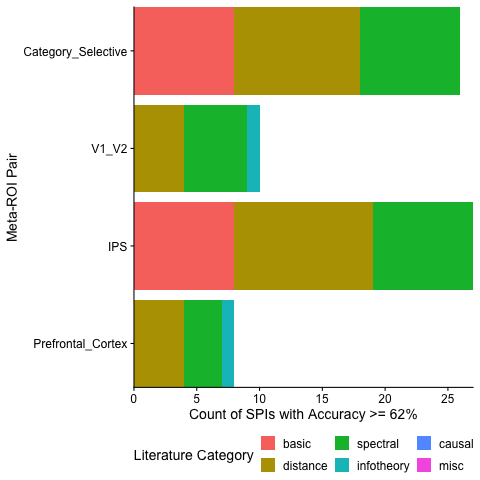

In [67]:
%%R -i unique_SPIs_from_long,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_from_long %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = factor(Literature_category,
                                                                        levels = c("basic", "distance", "spectral", 
                                                                        "infotheory", "causal", "misc")))) %>% 
        mutate(meta_ROI_from = factor(meta_ROI_from, 
        levels = rev(c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_from, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 62%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_from_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


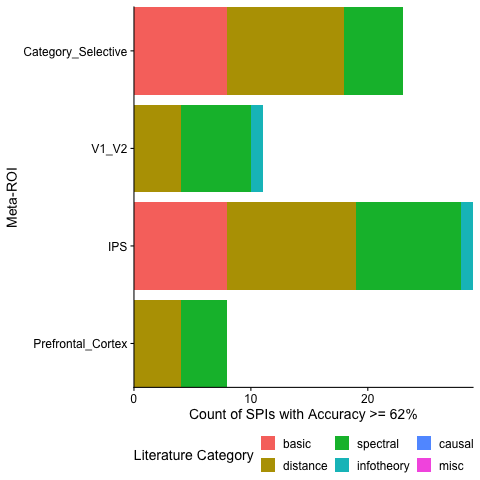

In [70]:
%%R -i unique_SPIs_to_long,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_to_long %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = factor(Literature_category,
                                                                        levels = c("basic", "distance", "spectral", 
                                                                        "infotheory", "causal", "misc")))) %>% 
        mutate(meta_ROI_to = factor(meta_ROI_to, 
        levels = rev(c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_to, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 62%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_to_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

## What is the max performance by SPI across all analyses?

In [107]:
%%R -i averaged_stimulus_type_classification_res,pyspi_SPI_info

averaged_stimulus_type_classification_res %>% 
    group_by(SPI) %>% 
    filter(accuracy==max(accuracy, na.rm=T)) %>%
    ungroup() %>% 
    distinct(SPI, accuracy) %>% 
    filter(accuracy > 0.5) %>% 
    left_join(., pyspi_SPI_info) %>% 
    mutate(SPI = fct_reorder(SPI, accuracy, .desc=F),
           Literature_category = factor(Literature_category, 
                                        levels = c("basic", "distance", "spectral", 
                                        "infotheory", "causal", "misc"))) %>%
    ggplot(data=., mapping=aes(x=SPI, y=100*accuracy)) +
    geom_point(aes(color=Literature_category), alpha=0.8, stroke=0) +
    # Add a line from the point to the x-axis
    geom_segment(aes(xend=SPI, yend=50, color=Literature_category)) +
    # geom_bar(aes(fill=Literature_category), stat="identity") +
    geom_line() +
    ylab("Maximum Classification Accuracy (%)") +
    coord_flip() +
    scale_y_continuous(expand=c(0,0)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none")
ggsave('../plots/inter_subject_classification/Max_classification_performance_by_SPI_category.svg', width=3, height=8, units='in', dpi=300)

Joining with `by = join_by(SPI)`
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
